# argument order

In [30]:
import pandas as pd
from cosmograph import cosmo
from i2 import Sig
from i2.signatures import parameter_to_dict

cosmo_sig = Sig(cosmo)
pd.DataFrame(map(parameter_to_dict, cosmo_sig.params))


,name,kind,default,annotation
0,data,1,None,<class 'inspect._empty'>
1,points,3,None,<class 'object'>
2,links,3,None,<class 'object'>
3,disable_simulation,3,None,<class 'bool'>
4,simulation_decay,3,None,<class 'float'>
...,...,...,...,...
91,clicked_point_id,3,None,<class 'str'>
92,selected_point_indices,3,None,list[int]
93,selected_point_ids,3,None,list[str]
94,changePoints,3,None,"typing.Callable[[typing.Dict[str, typing.Any]]..."


In [81]:
from cosmograph._code_sync import order_cosmo_params, print_param_spec_code_lines

old_sig = Sig(cosmo)
new_sig = order_cosmo_params(cosmo)
print_param_spec_code_lines(new_sig)


	data=None,
	*,
	points : object = None,
	links : object = None,
	point_x_by : str = None,
	point_y_by : str = None,
	point_size_by : str = None,
	point_color_by : str = None,
	point_label_by : str = None,
	point_color : Union[str, list[float]] = None,
	point_greyout_opacity : float = None,
	point_size : float = None,
	point_size_scale : float = None,
	point_sampling_distance : int = None,
	point_id_by : str = None,
	point_index_by : str = None,
	point_size_range : list[float] = None,
	point_label_weight_by : str = None,
	point_cluster_by : str = None,
	point_cluster_strength_by : str = None,
	point_include_columns : list[str] = None,
	link_color : Union[str, list[float]] = None,
	link_greyout_opacity : float = None,
	link_width : float = None,
	link_width_scale : float = None,
	link_arrows : bool = None,
	link_arrows_size_scale : float = None,
	link_visibility_distance_range : list[float] = None,
	link_visibility_min_transparency : float = None,
	link_source_by : str = None,
	link_sou

In [82]:
print(f"{old_sig == new_sig = }")

old_sig == new_sig = True


## egress

In [1]:
from functools import partial
from cosmograph import cosmo
import pandas as pd

from tabled import get_table  # TODO: Replace by pd.read_parquet when url CORS is solved


def map_mode(df, *, col='mode', mapping={0: 'Major', 1: 'Minor'}):
    assert df[col].value_counts().shape[0] == len(mapping)
    df[col] = df[col].replace(mapping)
    return df


In [2]:
over_half_bil_url = 'https://d.cosmograph.app/projects/spotify_playlists/over_500_million_streams.parquet'
rolling_stones_500_url = 'https://d.cosmograph.app/projects/spotify_playlists/rolling_stone_500_greatest_songs.parquet'

over_half_bil = get_table(over_half_bil_url)
rolling_stones_500 = get_table(rolling_stones_500_url)

print(f"{over_half_bil.shape=}")
over_half_bil.iloc[0]


assert over_half_bil['mode'].value_counts().shape[0] == 2
# replace 0 by "Major" and 1 by "minor"
over_half_bil['mode'] = over_half_bil['mode'].replace({0: 'Major', 1: 'Minor'})

print(f"{over_half_bil.shape=}")
over_half_bil.iloc[0]

over_half_bil.shape=(1875, 42)
over_half_bil.shape=(1875, 42)


name                                                    Blinding Lights
popularity                                                           18
explicit                                                          False
album_name                                              Blinding Lights
album_release_date                                           2019-11-29
album_release_year                                                 2019
url                   https://open.spotify.com/track/0sf12qNH5qcw8qp...
artist_list                                                [The Weeknd]
first_artist                                                 The Weeknd
id                                               0sf12qNH5qcw8qpgymFOqD
duration_ms                                                      201573
is_local                                                          False
album_total_tracks                                                    1
album_images          [{'height': 640, 'url': 'https://i.scdn.co

In [3]:
# Q: What does point_size and point_range do to the size? What can we do to get the size in a good ballpark?
# Q: How can I specify if my color_by is numerical or categorical?
# Q: How do I control the color palette?
cosmo(
    over_half_bil,
    point_x_by='x',
    point_y_by='y',
    point_size_by='popularity',
    point_color_by='mode',
    point_size_range=(0.01, 0.2),
)

Cosmograph(background_color=None, focused_point_ring_color=None, hovered_point_ring_color=None, link_color=Non…

In [10]:
over_half_bil['tempo'].describe()

count    1875.00000
mean      120.33286
std        28.24217
min        48.71800
25%        98.03300
50%       118.81800
75%       137.77050
max       205.84600
Name: tempo, dtype: float64

In [11]:
def custom_color_col(params):
    if callable(params.get('point_color_by')):
        point_size_by_func = params['point_color_by']
        points_copy = params['points'].copy()  # TODO: Perhaps put the copy systematically?
        # apply point_color_by_func to each row of points_copy to get the value of _point_color_by column
        points_copy['_point_color_by'] = points_copy.apply(point_size_by_func, axis=1)
        params['point_color_by'] = '_point_color_by'
        params['points'] = points_copy

    return params

middle_tempo = over_half_bil['tempo'].median() * 1.0

cosmo(
    over_half_bil,
    ingress=custom_color_col, #cosmo.ingress.add(custom_color_col),
    point_x_by='x',
    point_y_by='y',
    point_color_by=lambda x: int(x['tempo'] > middle_tempo),
    point_size=0.3,
)

Cosmograph(background_color=None, focused_point_ring_color=None, hovered_point_ring_color=None, link_color=Non…

In [12]:
f = cosmo(
    ingress=custom_color_col, #cosmo.ingress.add(custom_color_col),
    point_x_by='x',
    point_y_by='y',
    point_color_by=lambda x: int(x['tempo'] > middle_tempo),
    point_size=0.3,
)

In [14]:
f(over_half_bil)

Cosmograph(background_color=None, focused_point_ring_color=None, hovered_point_ring_color=None, link_color=Non…

In [22]:
over_half_bil['mode'].value_counts()

mode
1    1116
0     759
Name: count, dtype: int64

<Axes: xlabel='x', ylabel='y'>

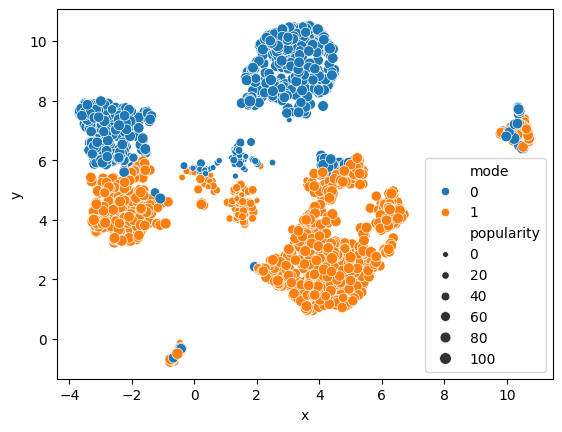

In [16]:
from seaborn import scatterplot

scatterplot(over_half_bil, x='x', y='y', size='popularity', hue='mode')

# Partial cosmo

In [1]:
from functools import partial
from cosmograph import cosmo
import pandas as pd

from tabled import get_table  # TODO: Replace by pd.read_parquet when url CORS is solved

In [2]:
over_half_bil_url = 'https://d.cosmograph.app/projects/spotify_playlists/over_500_million_streams.parquet'
rolling_stones_500_url = 'https://d.cosmograph.app/projects/spotify_playlists/rolling_stone_500_greatest_songs.parquet'

over_half_bil = get_table(over_half_bil_url)
rolling_stones_500 = get_table(rolling_stones_500_url)

print(f"{over_half_bil.shape=}")
over_half_bil.iloc[0]

over_half_bil.shape=(1875, 42)


name                                                    Blinding Lights
popularity                                                           18
explicit                                                          False
album_name                                              Blinding Lights
album_release_date                                           2019-11-29
album_release_year                                                 2019
url                   https://open.spotify.com/track/0sf12qNH5qcw8qp...
artist_list                                                [The Weeknd]
first_artist                                                 The Weeknd
id                                               0sf12qNH5qcw8qpgymFOqD
duration_ms                                                      201573
is_local                                                          False
album_total_tracks                                                    1
album_images          [{'height': 640, 'url': 'https://i.scdn.co

In [ ]:
cosmo(
    data,
)

In [15]:
data = {
    'Quest_Title': [
        'Dragon Hunt',
        'Mystic Voyage',
        'Treasure Seekers'
    ],
    'Map_X': [120, 450, 100],
    'Map_Y': [75, 320, 210],
    'Aura_Color': ['Crimson', 'Azure', 'Emerald'],
    'Gear_Size': [15, 20, 10]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

cosmo(
    df,
    point_x_by='Map_X',
    point_y_by='Map_Y',
    point_color_by='Aura_Color',
    point_size_by='Gear_Size',
    point_size_scale=7,
    point_label_by='Quest_Title',
)

        Quest_Title  Map_X  Map_Y Aura_Color  Gear_Size
0       Dragon Hunt    120     75    Crimson         15
1     Mystic Voyage    450    320      Azure         20
2  Treasure Seekers    100    210    Emerald         10


Cosmograph(background_color=None, focused_point_ring_color=None, hovered_point_ring_color=None, link_color=Non…

In [54]:
data = {
    'Quest_Title': [
        'Dragon Hunt',
        'Mystic Voyage',
        'Treasure Seekers'
    ],
    'Map_X': [120, 450, 100],
    'Map_Y': [75, 320, 210],
    'Aura_Color': ['Crimson', 'Azure', 'Emerald'],
    'Gear_Size': [15, 20, 10]
}

# Create the DataFrame
df = pd.DataFrame(data)

graph = cosmo(
    df,
    point_x_by='Map_X',
    point_y_by='Map_Y',
    point_color_by='Aura_Color',
    point_size_by='Gear_Size',
    point_size_scale=7,
    point_label_by='Quest_Title',
)

        Quest_Title  Map_X  Map_Y Aura_Color  Gear_Size
0       Dragon Hunt    120     75    Crimson         15
1     Mystic Voyage    450    320      Azure         20
2  Treasure Seekers    100    210    Emerald         10


In [63]:
from i2 import Sig
t = set([x for x in dir(graph) if not x.startswith('_')]) - set(Sig(cosmo).names)
import anywidget
assert isinstance(graph, anywidget.widget.AnyWidget)

In [30]:
# Example 2: Fantasy Potion Brewing

# Define the data with whimsical column names
data_potions = {
    'potion_name': [
        'Elixir of Vitality',
        'Draught of Invisibility',
        'Brew of Fireball'
    ],
    'Brewmaster': [
        'Elder Willow',
        'Mistress Shadow',
        'Master Ignis'
    ],
    'Ingredients': [
        'Dragon Scale, Phoenix Feather, Unicorn Tears',
        'Nightshade, Moonflower, Shadow Essence',
        'Fireroot, Lava Crystal, Unicorn Tears, Ember Dust'
    ],
    'Location_X': [500, 620, 450],
    'Location_Y': [300, 400, 350],
    'potion_color': ['Blue', 'White', 'Red'],
    'potion_difficulty': [25, 30, 20],
    'potion_popularity': [1, 2, 3]
}

# Create the DataFrame
df_potions = pd.DataFrame(data_potions)

# Display the DataFrame
print(df_potions)



               potion_name       Brewmaster  \
0       Elixir of Vitality     Elder Willow   
1  Draught of Invisibility  Mistress Shadow   
2         Brew of Fireball     Master Ignis   

                                         Ingredients  Location_X  Location_Y  \
0       Dragon Scale, Phoenix Feather, Unicorn Tears         500         300   
1             Nightshade, Moonflower, Shadow Essence         620         400   
2  Fireroot, Lava Crystal, Unicorn Tears, Ember Dust         450         350   

  potion_color  potion_difficulty  potion_popularity  
0         Blue                 25                  1  
1        White                 30                  2  
2          Red                 20                  3  


In [ ]:
asis = cosmo(
    df_potions,
    point_x_by='Location_X',
    point_y_by='Location_Y',
    point_label_by='potion_name',
    point_size_by='potion_difficulty',
    point_color_by='potion_color',
)
assert not callable(asis), 'widget is not callable!'
asis

Cosmograph(background_color=None, focused_point_ring_color=None, hovered_point_ring_color=None, link_color=Non…

In [56]:
from cosmograph import Cosmograph

assert isinstance(asis, Cosmograph)

In [55]:
my_cosmo = cosmo(
    # df_potions,  # not specifying data
    point_x_by='Location_X',
    point_y_by='Location_Y',
    point_label_by='potion_name',
    point_size_by='potion_difficulty',
    point_color_by='potion_color',
)
assert callable(my_cosmo), "Was expecting my_cosmo to be callable!"

widget_from_my_cosmo = my_cosmo(df_potions)  # here you get your widget

In [58]:
try:
    with_functional_color_failing = my_cosmo(
        df_potions,
        point_color_by=lambda x: int('Unicorn Tears' in x['Ingredients']),  # replace point_color_by with a function
    )
    # Expect error:
    # TraitError: The 'point_color_by' trait of a Cosmograph instance expected a unicode string, not the function '<lambda>'.
except Exception as e:
    print(f"{type(e)}")

<class 'traitlets.traitlets.TraitError'>


In [47]:
# 
def handle_functional_color(kwargs):
    if callable(kwargs.get('point_color_by')):
        point_color_by_func = kwargs['point_color_by']
        points_copy = kwargs['points'].copy()
        # apply point_color_by_func to each row of points_copy to get the value of _point_color_by column
        points_copy['_point_color_by'] = points_copy.apply(point_color_by_func, axis=1)
        kwargs['point_color_by'] = '_point_color_by'
        kwargs['points'] = points_copy

    return kwargs

with_functional_color = my_cosmo(
    df_potions,
    ingress=handle_functional_color,  # need to add this to be able to handle the functional point_color_by!
    point_color_by=lambda x: int('Unicorn Tears' in x['Ingredients']),
)
with_functional_color

Cosmograph(background_color=None, focused_point_ring_color=None, hovered_point_ring_color=None, link_color=Non…

In [4]:
import pandas as pd
from cosmograph import cosmo

single_link = {
    'points': [{'id': '0'}, {'id': '1'}],
    'links': [{'source': '0', 'target': '1'}],
}

points, links = map(pd.DataFrame, single_link.values())

g = cosmo(
    points=[{'id': '0'}, {'id': '1'}],
    links=[{'source': '0', 'target': '1'}],
    point_id_by='id',
    link_source_by='source',
    link_target_by='target',
    simulation_gravity=0,
    simulation_center=1,
)

AttributeError: 'list' object has no attribute 'select_dtypes'